# **Red neuronal convolucional para el diagnóstico de nódulos tiroideos según la clasificación EU-TIRADS**

## Por Alejandro Martínez Hernández

### Notebook 2/3

# Notas artículo profe

- **Ajuste del tamaño del lote:** Pequeños tamaños de lote tienden a funcionar mejor en situaciones de desbalance de clases, ya que ayudan a evitar el sobreajuste en la clase mayoritaria y mejoran la generalización.

- **Aumento de datos (Data Augmentation):** Implementar políticas de aumento de datos puede tener un impacto amplificado bajo condiciones de desbalance de clases, especialmente en la precisión de las clases minoritarias. Estrategias como flips horizontales, recortes aleatorios, y técnicas más sofisticadas como AugMix y AutoAugment pueden ser particularmente útiles.

- **Arquitecturas grandes y pre-entrenamiento:** Las arquitecturas más grandes tienden a sobreajustarse en conjuntos de datos desbalanceados, mientras que el pre-entrenamiento, especialmente el auto-supervisado, puede mejorar la representación de características y aumentar el rendimiento general. Este último es robusto a desequilibrios en los datos de entrenamiento y puede ser especialmente beneficioso.

- **Minimización Consciente de la Nitidez (Sharpness-Aware Minimization, SAM):** Modificar el SAM para aumentar la "planitud" en los términos de pérdida de las clases minoritarias puede mejorar la precisión de estos grupos al alejar los límites de decisión de las muestras minoritarias.
Suavizado de etiquetas (Label Smoothing): Aplicar suavizado de etiquetas, especialmente en ejemplos de clases minoritarias, puede prevenir el sobreajuste.

# **Procesamiento de datos**

Ya conociendo la estructura de los datos, estos deben ser preparados y nuevamente organizados para poder usarlos en algún entrenamiento de un modelo. 


## **Creación de directorios**

En la carpeta "organized" se crean otras carpetas para almacenar las imágenes (\images) y anotaciones (\notes) correspondientes que se van a usar para el entrenamiento.

Dentro de estas carpetas habrán otras que contendrán las imágenes y anotaciones crudas (\Raw) y otra para las imagenes y anotaciones ya procesadas (cropped).

In [7]:
import os
import shutil

def crear_subcarpetas(carpeta_principal, subcarpetas, subcarpeta_padre=None):
    """
    Crea subcarpetas dentro de una carpeta principal. Si se especifica una subcarpeta_padre,
    las subcarpetas se crearán dentro de esta.
    
    Parámetros:
    carpeta_principal (str): Ruta de la carpeta principal.
    subcarpetas (list): Lista de nombres de subcarpetas a crear.
    subcarpeta_padre (str): Nombre de la subcarpeta dentro de la cual se crearán nuevas subcarpetas.
    """
    # Determinar la ruta base donde se crearán las subcarpetas
    ruta_base = carpeta_principal if subcarpeta_padre is None else os.path.join(carpeta_principal, subcarpeta_padre)
    
    # Asegurar que la ruta base exista
    if not os.path.exists(ruta_base):
        os.makedirs(ruta_base)
    
    # Crear cada subcarpeta
    for subcarpeta in subcarpetas:
        os.makedirs(os.path.join(ruta_base, subcarpeta), exist_ok=True)

# Aplicación de función
carpeta_principal_1 = 'db_unal'
carpeta_principal_2 = 'db_unal/organized'
carpeta_principal_3 = 'db_unal/organized/images'
carpeta_principal_4 = 'db_unal/organized/notes'

subcarpetas_dentro_v1 = ['images', 'notes']  
subcarpetas_dentro_v2 = ['raw', 'cropped'] 
subcarpetas_dentro_v3 = ['high', 'low']   


# Crear subcarpetas adicionales dentro de db_unal/organized
crear_subcarpetas(carpeta_principal_1, subcarpetas_dentro_v1, 'organized')
crear_subcarpetas(carpeta_principal_2, subcarpetas_dentro_v2, 'images')
crear_subcarpetas(carpeta_principal_3, subcarpetas_dentro_v3, 'raw')
crear_subcarpetas(carpeta_principal_3, subcarpetas_dentro_v3, 'cropped')
crear_subcarpetas(carpeta_principal_4, subcarpetas_dentro_v3, 'raw')
crear_subcarpetas(carpeta_principal_4, subcarpetas_dentro_v3, 'cropped')

## **Importar los datos**

Se trae el dataframe *df_agrupado.csv* que se generó en el notebook *1_exploracion_datos.ipynb*

In [9]:
import pandas as pd
import os

def cargar_csv_de_forma_segura(ruta_archivo):
    """
    Carga un archivo CSV en un DataFrame de pandas de manera segura.
    
    Parámetros:
    ruta_archivo (str): La ruta completa al archivo CSV que se desea cargar.
    
    Retorna:
    DataFrame: Un DataFrame de pandas con los datos cargados desde el archivo CSV.
    None: Retorna None si ocurre un error durante la carga del archivo.
    """
    # Verificar si el archivo existe
    if not os.path.exists(ruta_archivo):
        print(f"El archivo {ruta_archivo} no existe.")
        return None
    
    try:
        # Usar pandas para leer el archivo CSV
        df = pd.read_csv(ruta_archivo)
        return df
    except pd.errors.EmptyDataError:
        print("El archivo está vacío.")
    except pd.errors.ParserError:
        print("Error al parsear el archivo CSV.")
    except Exception as e:
        print(f"Error al cargar el archivo: {e}")
    
    return None

# Cargar el archivo
ruta_archivo = 'df_agrupado.csv'
df_agrupado = cargar_csv_de_forma_segura(ruta_archivo)

# Mostar dataframe
df_agrupado



,Paciente,Edad,Sexo,Numero_imagen,TIRADS,Seg_radiologo_1,Seg_residente_1,Seg_residente_2,Composicion,Ecogenicidad,Margenes,Calcificaciones
0,1,NaN,NaN,1_1,high,1,1,0,NaN,NaN,NaN,NaN
1,1,NaN,NaN,1_2,high,1,1,1,NaN,NaN,NaN,NaN
2,2,49.0,F,2_1,high,1,1,1,solid,hyperechogenicity,well defined,NaN
3,3,31.0,F,3_1,high,1,1,1,spongiform,isoechogenicity,well defined,microcalcifications
4,4,37.0,F,4_1,low,1,1,1,spongiform,isoechogenicity,well defined,microcalcifications
...,...,...,...,...,...,...,...,...,...,...,...,...
167,146,NaN,NaN,146_1,low,1,1,0,NaN,NaN,NaN,NaN
168,147,NaN,NaN,147_1,high,1,1,0,NaN,NaN,NaN,NaN
169,148,37.0,F,148_1,high,1,1,0,solid,hypoechogenicity,well defined,NaN
170,149,78.0,M,149_1,high,1,1,0,NaN,NaN,NaN,NaN


Ya que se importó la base de datos que indica que imágenes y anotaciones se van a usar, se generará una copia de cada uno de estos a las carpetas \raw dentro de \organized.

In [10]:
import pandas as pd
import os
import shutil

ruta_origen = "db_unal/originals/DDTI_V1"
ruta_destino_base = "db_unal/organized/images/raw"

for index, row in df_agrupado.iterrows():
    nombre_imagen = row['Numero_imagen'] + '.jpg'  # Asumiendo que los nombres en el DataFrame no incluyen '.jpg'
    tirads_categoria = row['TIRADS'].lower()  # Asegurándonos de que el nombre del directorio esté en minúsculas

    # Construir la ruta completa del archivo de origen
    archivo_origen = os.path.join(ruta_origen, nombre_imagen)

    # Construir la ruta completa del archivo de destino
    ruta_destino = os.path.join(ruta_destino_base, tirads_categoria, nombre_imagen)

    # Verificar si el archivo existe antes de intentar copiarlo
    if os.path.exists(archivo_origen):
        # Crear el directorio destino si no existe
        os.makedirs(os.path.dirname(ruta_destino), exist_ok=True)
        # Copiar el archivo
        shutil.copy(archivo_origen, ruta_destino)
    else:
        print(f"No se encontró el archivo {archivo_origen}")

## **Recortar las imágenes**

Para comparar el procesamiento de las imágenes y centrarse en solo el ultrasonido, se realiza un recorte tratando de identificar los bordes.

In [21]:
import cv2
import os


def ajustar_niveles(imagen, nivel_min, nivel_max):
    """
    Ajusta los niveles de brillo y contraste de una imagen.

    Parameters:
    imagen (ndarray): Imagen de entrada en formato de numpy array.
    nivel_min (int): Valor mínimo del rango de salida.
    nivel_max (int): Valor máximo del rango de salida.

    Returns:
    ndarray: Imagen con los niveles ajustados.
    """
    return cv2.normalize(imagen, None, alpha=nivel_min, beta=nivel_max, norm_type=cv2.NORM_MINMAX)

def encontrar_y_recortar_imagen(input_path, output_path):
    """
    Encuentra la región de interés en una imagen de ultrasonido y la recorta,
    manteniendo los niveles originales de brillo y contraste.

    Parameters:
    input_path (str): Ruta de la imagen de entrada.
    output_path (str): Ruta donde se guardará la imagen recortada.
    """
    imagen_original = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
    imagen_gris = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2GRAY)
    imagen_contrastada = ajustar_niveles(imagen_gris, 0, 255)
    _, imagen_binaria = cv2.threshold(imagen_contrastada, 1, 255, cv2.THRESH_BINARY)
    contornos, _ = cv2.findContours(imagen_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contorno in contornos:
        x, y, ancho, alto = cv2.boundingRect(contorno)
        borde_mas_corto = min(ancho, alto)
        borde_mas_largo = max(ancho, alto)
        proporcion = borde_mas_largo / borde_mas_corto

        if borde_mas_corto >= 100 and proporcion <= 2:
            recorte = imagen_original[y:y+alto, x:x+ancho]

            # Porcentaje de reducción
            porcentaje = 0.1  # Reducir 10% de cada borde

            # Calcula la cantidad de píxeles a reducir en cada dirección
            reduccion_x = int(ancho * porcentaje)
            reduccion_y = int(alto * porcentaje)

            # Aplica el recorte adicional
            recorte_final = recorte[reduccion_y:alto-reduccion_y, reduccion_x:ancho-reduccion_x]

            cv2.imwrite(output_path, recorte_final)
            break

def ubicar(input_folder, output_folder):
    """
    Procesa todas las imágenes en un directorio, recortando regiones de interés
    según especificado en `encontrar_y_recortar_imagen`.

    Parameters:
    input_folder (str): Directorio que contiene las imágenes de entrada.
    output_folder (str): Directorio donde se guardarán las imágenes recortadas.
    """
    for filename in os.listdir(input_folder):
        try:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                input_path = os.path.join(input_folder, filename)
                base_name = filename.rsplit('.', 1)[0] + '.jpg'
                output_path = os.path.join(output_folder, base_name)
                
                try:
                    encontrar_y_recortar_imagen(str(input_path), str(output_path))
                except Exception as e:
                    print(f"No se pudo procesar el archivo {filename}: {e}")
        except Exception as e:
            print(f"Error al manejar el archivo {filename}: {e}")



# high
input_folder_1 = 'db_unal/organized/images/raw/high'
output_folder_1 = 'db_unal/organized/images/cropped/high'

# low
input_folder_3 = 'db_unal/organized/images/raw/low'
output_folder_3 = 'db_unal/organized/images/cropped/low'


# Procesar imágenes
ubicar(input_folder_1, output_folder_1)
ubicar(input_folder_3, output_folder_3)

### **Ejemplos de las imágenes recortadas**

Una vez recortadas y organizadas, estas serán las imágenes que se analizarán

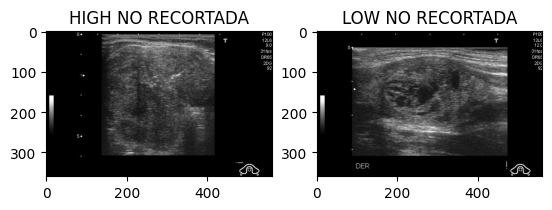

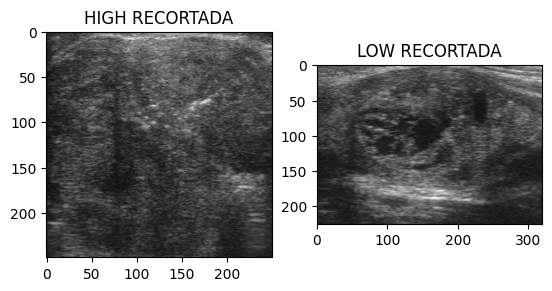

In [22]:
import cv2
import matplotlib.pyplot as plt


# IMÁGENES NO RECORTADAS
# Fijar la dirección de cualquiera de las dos imágenes
folder_1 = 'db_unal/organized/images/raw/high/1_1.jpg' 
folder_2 = 'db_unal/organized/images/raw/low/4_1.jpg'

# Leer las direcciones con cv2
img_high = cv2.imread(folder_1)
img_low = cv2.imread(folder_2)

# Convertir el perfil de color de BGR a RGB
img_high_rgb = cv2.cvtColor(img_high, cv2.COLOR_BGR2RGB)
img_low_rgb = cv2.cvtColor(img_low, cv2.COLOR_BGR2RGB)

# Crear figura y subfiguras
plt.figure()
plt.subplot(1,2,1)
plt.title('HIGH NO RECORTADA')
plt.imshow(img_high_rgb)
plt.subplot(1,2,2)
plt.title('LOW NO RECORTADA')
plt.imshow(img_low_rgb)
plt.show()

#_________________________________________________________

# IMÁGENES RECORTADAS
# Fijar la dirección de cualquiera de las dos imágenes
folder_1 = 'db_unal/organized/images/cropped/high/1_1.jpg' 
folder_2 = 'db_unal/organized/images/cropped/low/4_1.jpg'

# Leer las direcciones con cv2
img_high = cv2.imread(folder_1)
img_low = cv2.imread(folder_2)

# Convertir el perfil de color de BGR a RGB
img_high_rgb = cv2.cvtColor(img_high, cv2.COLOR_BGR2RGB)
img_low_rgb = cv2.cvtColor(img_low, cv2.COLOR_BGR2RGB)

# Crear figura y subfiguras
plt.figure()
plt.subplot(1,2,1)
plt.title('HIGH RECORTADA')
plt.imshow(img_high_rgb)
plt.subplot(1,2,2)
plt.title('LOW RECORTADA')
plt.imshow(img_low_rgb)
plt.show()